# Zero-Shot Visual Prompting Task

## Installation and Setup
For installation and setting up the repo, please refer to the [Installation Notebook](000_install.ipynb). 

In [1]:
import os
from utils.io import setup_repo, seed_everywhere

# Setup repo and checkout to the branch with the tutorials
setup_repo(
    git_url="https://github.com/openvinotoolkit/training_extensions.git",
    branch='tutorials/cvpr24',
)
os.getcwd()
seed_everywhere(seed=5)

## Prepare the Data

The first step is to prepare the dataset. If you haven't downloaded the dataset yet, you could download it via the following:


In [2]:
from notebooks.utils.download import download_dataset

download_dataset(
    url=(
        "https://github.com/openvinotoolkit/training_extensions/releases/download"
        "/fruits_and_vegetables_dataset/fruits_and_vegetables.zip"
    ),
    extract_to="data/fruits_and_vegetables"
)

The dataset is already available in data/fruits_and_vegetables


The above cell will check if the dataset is already downloaded. If not, it will download the dataset and extract it to the `data` directory. Now that we have the dataset, let's prepare the data for the rest of the tasks.

In [3]:
import torch
from otx.core.config.data import DataModuleConfig, SubsetConfig
from otx.core.data.module import OTXDataModule
from otx.core.data.transform_libs.torchvision import PadtoSquare, ResizetoLongestEdge
from torchvision.transforms.v2 import Normalize, ToDtype

data_root = "data/fruits_and_vegetables/"

transforms = [
    ResizetoLongestEdge(size=1024, antialias=True),
    PadtoSquare(),
    ToDtype(dtype=torch.float32, scale=False),
    Normalize(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], inplace=False)
]

datamodule = OTXDataModule(
    task="ZERO_SHOT_VISUAL_PROMPTING",
    config=DataModuleConfig(
        data_format="datumaro",
        data_root=data_root,
        train_subset=SubsetConfig(
            subset_name="train",
            batch_size=1,
            num_workers=4,
            transform_lib_type="TORCHVISION",
            transforms=transforms,
        ),
        val_subset=SubsetConfig(
            subset_name="val",
            batch_size=1,
            num_workers=4,
            transform_lib_type="TORCHVISION",
            transforms=transforms,
        ),
        test_subset=SubsetConfig(
            subset_name="test",
            batch_size=1,
            num_workers=4,
            transform_lib_type="TORCHVISION",
            transforms=transforms,
        ),
    ),
)

/home/harimkan/workspace/repo/otx-regression/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/harimkan/workspace/repo/otx-regression/src/otx/core/data/module.py:62: UserWarning: There are empty annotation items in train set, Of these, only 0.0% are used.
  dataset = pre_filtering(dataset, self.config.data_format, self.config.unannotated_items_ratio)


## Zero-Shot SAM
We will try Segment Anything Model within the zero-shot setting such we won't use any annotations or perform any training. We will instead use the model as is and perform inference on the images. Depending on the accuracy of the model, we could even use it to create annotations for the images. Let's import the zero-shot SAM model and perform inference on the images.

In [4]:
from otx.algo.visual_prompting.zero_shot_segment_anything import OTXZeroShotSegmentAnything

zero_shot_model = OTXZeroShotSegmentAnything(backbone="tiny_vit", label_info=datamodule.label_info)

The above cell creates `ZeroShotSAM` model. Let's try to perform inference on a validation image. 

In [5]:
dataloader = iter(datamodule.val_dataloader())

batch = next(dataloader)
results = zero_shot_model.learn(batch)

Now that we have the input image and output predictions, we could visualize them. Let's visualize the input image and the predicted masks.

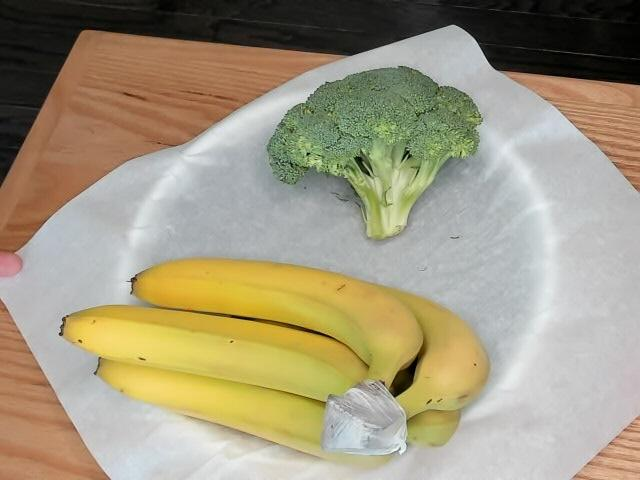

In [6]:
from torchvision.transforms import ToPILImage

ToPILImage()(batch.images[0])

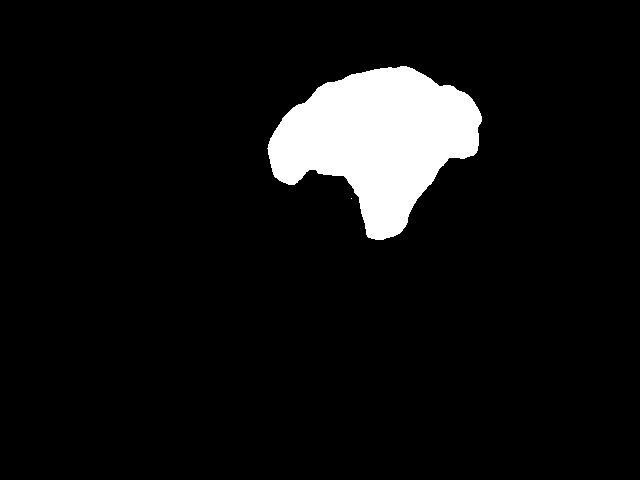

In [7]:
# Visualize the broccoli mask
ToPILImage()(results[1][0][2])

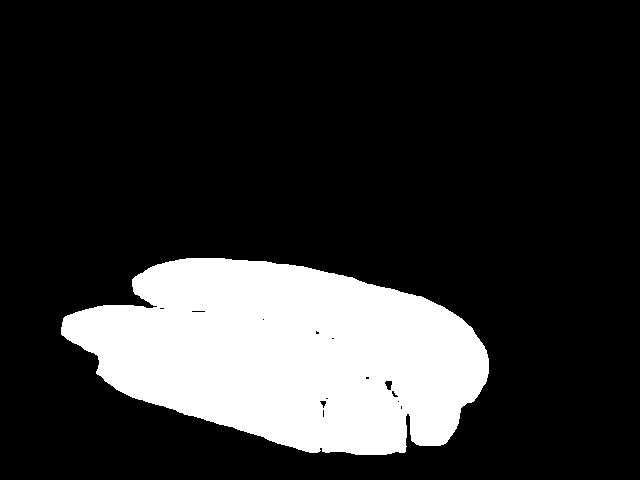

In [8]:
# Visualize the banana mask
ToPILImage()(results[1][0][9])

Let's try another example from the test set.

In [9]:
_ = next(dataloader)
batch2 = next(dataloader)


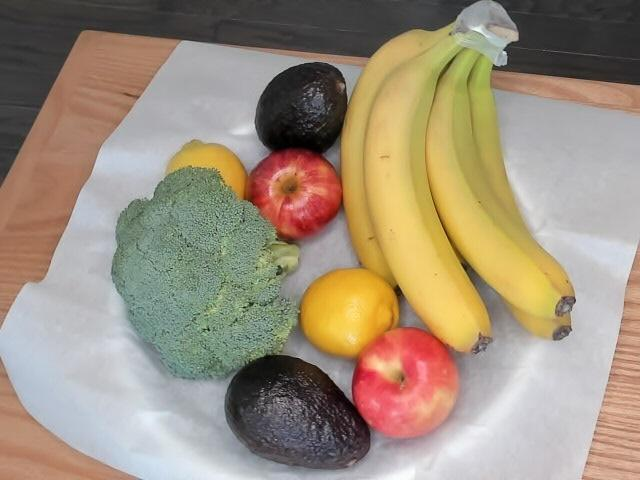

In [10]:
# batch2.images.shape returns torch.Size([1, 3, 480, 640])
# so we get rid of the first dimension to visualize the image
ToPILImage()(batch2.images[0])

In [11]:
results2 = zero_shot_model.infer(batch2, **results[0])

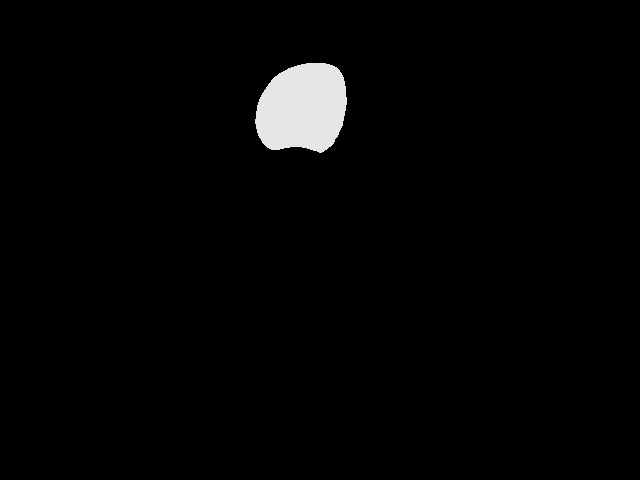

In [16]:
# Visualize the avocado mask
ToPILImage()(results2.masks[0][0])

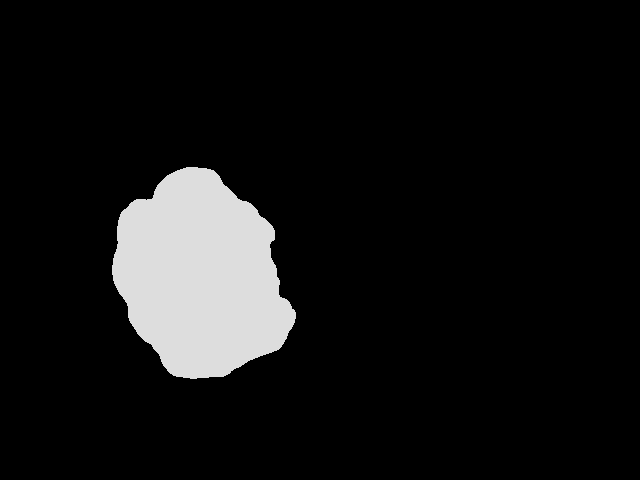

In [18]:
# Visualize the broccoli mask
ToPILImage()(results2.masks[0][1])

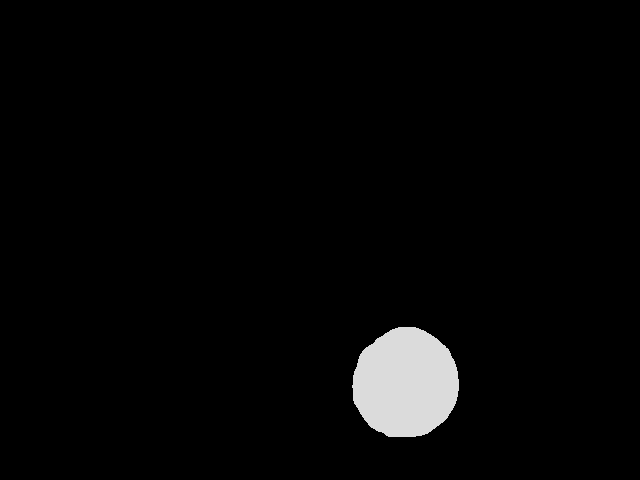

In [19]:
# Visualize the apple mask
ToPILImage()(results2.masks[0][2])

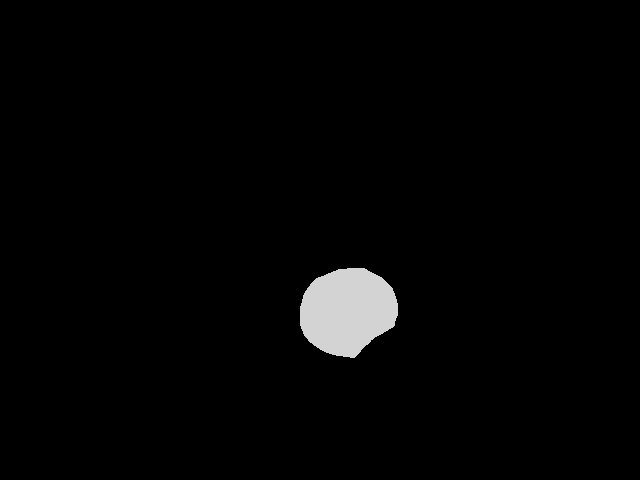

In [21]:
# Visualize the lemon mask
ToPILImage()(results2.masks[0][4])

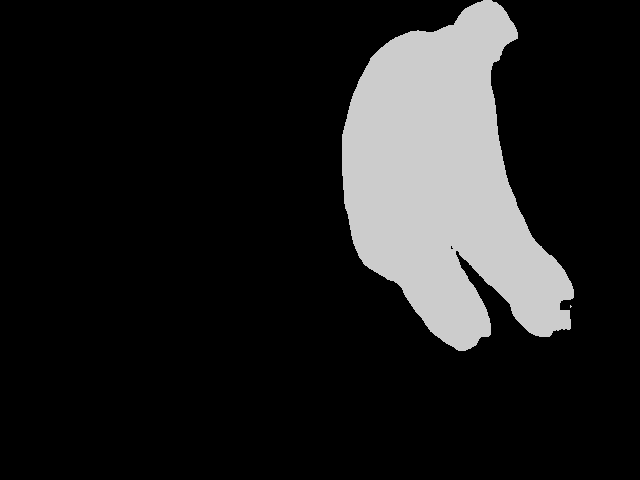

In [23]:
# Visualize the banana mask
ToPILImage()(results2.masks[0][6])

In [ ]:
# TODO: Get class id's so that we could visualize by passing the class-name

This notebook demonstrates how to use the Zero-Shot SAM model to perform inference on the images. The model can be used to perform segmentation on the images without any annotations. This could be useful in scenarios where we don't have access to annotations or when we want to quickly perform segmentation on the images.